In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn import datasets
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer

from sklearn.model_selection import (
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline

Here we import data from XYZ company

In [22]:
df = pd.read_csv('data/xyz.csv')
df.head()

,Date,PX_LAST,DCF_Proxy,Comps_Proxy,Precedents_Proxy
0,2000-03-31,52.535192,54.669143,NaN,47.455227
1,2000-06-30,52.317763,55.220905,54.455778,47.994612
2,2000-09-30,53.514381,56.807985,52.057804,50.446929
3,2000-12-31,56.570475,59.112819,58.375365,59.720223
4,2001-03-31,58.081069,60.652486,55.159699,58.318580


Here we will split the data into train and test portions. 

In [23]:
train_df, test_df = train_test_split(df, test_size = 0.2)

In [24]:
y = df['PX_LAST']
X = df.drop(columns = ('PX_LAST'))

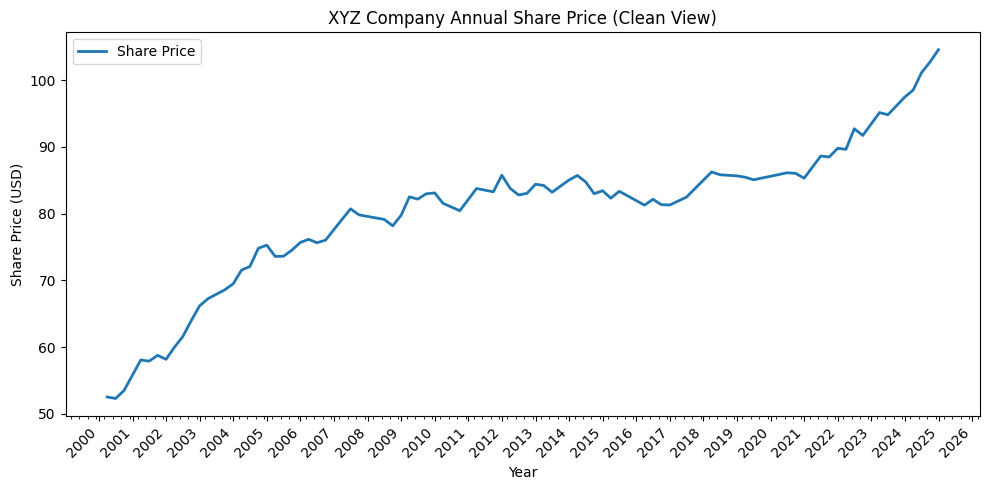

In [27]:
# 1. Ensure Date is datetime and sorted
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df = train_df.sort_values('Date')

# 2. Plot only share price with a clean line
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(
    train_df['Date'],
    train_df['PX_LAST'],
    linewidth=2,        # solid line
    marker='',          # no marker
    label='Share Price'
)

# 3. Format the x-axis for readability
ax.xaxis.set_major_locator(mdates.YearLocator())  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(3,6,9,12)))  

plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# 4. Labels, title, legend
ax.set_xlabel('Year')
ax.set_ylabel('Share Price (USD)')
ax.set_title('XYZ Company Annual Share Price (Clean View)')
ax.legend()

plt.tight_layout()
plt.show()

The stock price data generated here is from averaging the price trend of four famous big tech companies: Microsoft, Apple, Amazon, Meta.

In [30]:
print(train_df.info())
print(train_df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 80 entries, 0 to 99
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              80 non-null     datetime64[ns]
 1   PX_LAST           80 non-null     float64       
 2   DCF_Proxy         70 non-null     float64       
 3   Comps_Proxy       73 non-null     float64       
 4   Precedents_Proxy  74 non-null     float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 3.8 KB
None
                      Date     PX_LAST   DCF_Proxy  Comps_Proxy  \
count                   80   80.000000   70.000000    73.000000   
mean   2012-02-15 09:18:00   79.913730   83.648492    81.023618   
min    2000-03-31 00:00:00   52.317763   54.669143    52.057804   
25%    2005-09-07 00:00:00   75.168820   78.665434    76.066649   
50%    2012-02-14 12:00:00   82.505344   86.635144    81.163353   
75%    2018-04-22 18:00:00   85.520732   88.467899    88.04

For simplicity, I assumed a readily available proxy for each valuation method. In practice, you’ll need to collect and engineer these features yourself:

<ul>
  <li><strong>Comps &amp; Precedents:</strong>
    <ol>
      <li>Select an appropriate peer group and relevant past transactions</li>
      <li>Use the Bloomberg Terminal to pull each peer’s and deal’s EV/EBITDA (or other multiples) on a quarterly basis</li>
      <li>Convert multiples into per-share values by multiplying by the company’s market cap (<code>CUR_MKT_CAP</code>) and dividing by shares outstanding (<code>EQY_SH_OUT</code>)</li>
    </ol>
  </li>
  <li><strong>DCF Proxy:</strong> Reference the <a href="https://github.com/scfengv/Stock-Valuation">scfengv/Stock-Valuation</a> repo to generate DCF-based target prices and use those as your DCF proxy.</li>
</ul>

This data's purpose is to fully test the functionality of the model, therefore various edge cases are included:
<ul>
  <li><strong>Missing Values:</strong>
    <ul>
      <li><code>PX_LAST</code>: 0 missing</li>
      <li><code>DCF_Proxy</code>: ~10% missing</li>
      <li><code>Comps_Proxy</code>: ~8% missing</li>
      <li><code>Precedents_Proxy</code>: ~10% missing</li>
    </ul>
  </li>
  <li><strong>Zero-Value Inputs:</strong>
    <ul>
      <li>None (all zeros were converted to <code>NaN</code>)</li>
    </ul>
  </li>
  <li><strong>Negative Values:</strong>
    <ul>
      <li>None (all negatives were converted to <code>NaN</code>)</li>
    </ul>
  </li>
  <li><strong>Flat Periods:</strong> (≥3 identical quarters in a row)
    <ul>
      <li><code>PX_LAST</code>: one 3-quarter flat segment</li>
      <li><code>Comps_Proxy</code>: one 3-quarter flat segment</li>
    </ul>
  </li>
  <li><strong>Outliers (|z| > 3):</strong>
    <ul>
      <li><code>DCF_Proxy</code>: 2 extreme upward spikes</li>
      <li><code>Precedents_Proxy</code>: 2 extreme upward spikes</li>
    </ul>
  </li>
</ul>


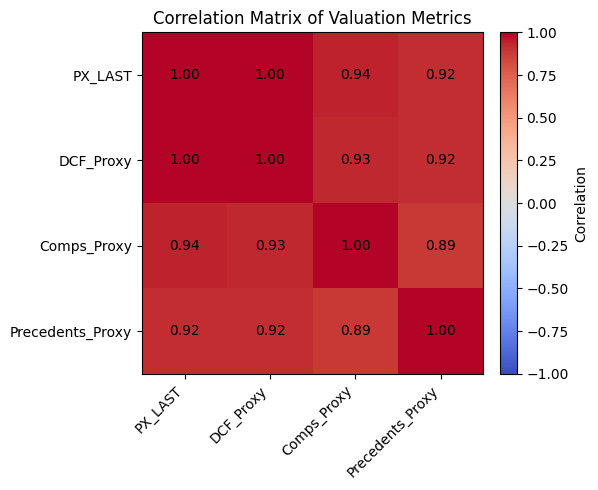

In [31]:
# 2. Compute the correlation matrix on the relevant columns
cols = ["PX_LAST", "DCF_Proxy", "Comps_Proxy", "Precedents_Proxy"]
corr = train_df[cols].corr()

# 3. Plot the heatmap
fig, ax = plt.subplots(figsize=(6, 5))
cax = ax.imshow(corr, vmin=-1, vmax=1, cmap="coolwarm")

# 4. Ticks & labels
ax.set_xticks(np.arange(len(cols)))
ax.set_yticks(np.arange(len(cols)))
ax.set_xticklabels(cols)
ax.set_yticklabels(cols)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# 5. Annotate correlation values
for i in range(len(cols)):
    for j in range(len(cols)):
        ax.text(j, i, f"{corr.iloc[i, j]:.2f}", ha="center", va="center", color="black")

# 6. Colorbar & title
fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04, label="Correlation")
ax.set_title("Correlation Matrix of Valuation Metrics")

plt.tight_layout()
plt.show()

<p>Below is a summary of the <strong>realistic market frictions</strong> we applied when generating the synthetic XYZ dataset:</p>

<ul>
  <li><strong>Timing mismatches:</strong> each proxy was randomly lagged by 0–2 quarters to simulate data reporting delays</li>
  <li><strong>High‐frequency noise &amp; sentiment shocks:</strong> added Gaussian noise (~5% volatility) plus occasional ±15–20% jumps to <code>PX_LAST</code></li>
  <li><strong>Forecast errors:</strong> per‐quarter multiplicative deviations (±10%) applied to each proxy value</li>
  <li><strong>Staleness:</strong> randomly “froze” each proxy for 3 consecutive quarters to mimic delayed analyst updates</li>
  <li><strong>Missing values:</strong> ~10% of proxy entries set to <code>NaN</code> to represent data gaps</li>
</ul>

<p>These transformations ensure our synthetic data embeds the same timing, noise, and data‐quality challenges you’ll face with real market inputs.</p>
